In [6]:
import random, time, cv2
from matplotlib import pyplot as plt
from pydnet import darknet

random.seed(3)
#input_file = './data/test_color/b6ecda23586a6ba5_jpg.rf.d737139968dd3f08447305aa7b7f6002.jpg'
input_file = './data/valid/f5d1729aa333b284_jpg.rf.0a241e6c8cfebc2ee5a5a931954e5da7.jpg'

config_file = './lpr-yolov4-tiny-3l.cfg'
data_file = './lpr.data'
weights_file = './lpr-yolov4-tiny-3l_20000.weights'

thresh = 0.5

In [7]:
# crashes the kernel if any of the files cannot be found
network, class_names, class_colors = darknet.load_network(    
    config_file,
    data_file,
    weights_file,
)

width = darknet.network_width(network)    
height = darknet.network_height(network)    
darknet_image = darknet.make_image(width, height, 3)    

image =  cv2.imread(input_file)
height_orig, width_orig, channels_orig = image.shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_resized = cv2.resize(image_rgb, (width, height),    
                           interpolation=cv2.INTER_LINEAR)    

darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())    

start = time.time()
detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
stop = time.time()

darknet.free_image(darknet_image)    
boxed = darknet.draw_boxes(detections, image_resized, class_colors)
image_boxes = cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB)

darknet.print_detections(detections, True)

print(f'Time: {round(stop-start, 4)} s -- FPS: {int(1/(stop-start))}')

   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    608 x 608 x   3 ->  304 x 304 x  32 0.160 BF
   1 conv     64       3 x 3/ 2    304 x 304 x  32 ->  152 x 152 x  64 0.852 BF
   2 conv     64       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x  64 1.703 BF
   3 route  2 		                       1/2 ->  152 x 152 x  32 
   4 conv     32       3 x 3/ 1    152 x 152 x  32 ->  152 x 152 x  32 0.426 BF
   5 conv     32       3 x 3/ 1    152 x 152 x  32 ->  152 x 152 x  32 0.426 BF
   6 route  5 4 	                           ->  152 x 152 x  64 
   7 conv     64       1 x 1/ 1    152 x 152 x  64 ->  152 x 152 x  64 0.189 BF
   8 route  2 7 	                           ->  152 x 152 x 128 
   9 max                2x 2/ 2    152 x 152 x 128 ->   76 x  76 x 128 0.003 BF
  10 conv    128       3 x 3/ 1     76 x  76 x 128 ->   76 x  76 x 128 1.703 BF
  11 route  10 		                       1/2 ->   76 x  76 x  64 
  12 conv     64       3 x 3/ 1  


 seen 64, trained: 1260 K-images (19 Kilo-batches_64) 
Loaded - names_list: lpr.names, classes = 2 
 Try to load cfg: ./lpr-yolov4-tiny-3l.cfg, weights: ./lpr-yolov4-tiny-3l_20000.weights, clear = 0 
mini_batch = 1, batch = 7, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
 Try to load weights: ./lpr-yolov4-tiny-3l_20000.weights 

Objects:
car: 76.47%    (left_x: 306   top_y:  305   width:   477   height:  437)
license-plate: 77.41%    (left_x: 68   top_y:  202   width:   34   height:  23)
Time: 0.7305 s -- FPS: 1


In [3]:
rcol = lambda: (random.randint(0, 255),
               random.randint(0, 255),
               random.randint(0, 255))

def get_scale_factor(orig, image_resized=None):
    if image_resized is None:
        return (1,1)
    o_height, o_width, o_channels = orig.shape
    r_height, r_width, r_channels = image_resized.shape
    fx = o_width/r_width
    fy = o_height/r_height
    return fx, fy

def bbox_to_opencv(bbox, img, image_resized=None):
    points = darknet.bbox2points(bbox)
    sx, sy, ex, ey = points
    #print(points)
    fx, fy = get_scale_factor(img, image_resized)
    start, end = (int(sx*fx), int(sy*fy)), (int(ex*fx), int(ey*fy))
    return start, end

def crop_to_bbox(bbox, img, image_resized=None):
    start, end = bbox_to_opencv(bbox, img, image_resized)
    sx, sy = start
    ex, ey = end
    crop = img[max(0, sy):max(0, ey),
               max(0, sx):max(0, ex)]
    return crop
    
def draw_bboxes(img, dets, image_resized=None):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1
    font_thickness = 1
    text_color = (255, 255, 255)
    for det in dets:
        name, conf, bbox = det
        text = f'{name}: {conf}'
        color = rcol()
        
        start, end = bbox_to_opencv(bbox, img, image_resized)
        cv2.rectangle(img, start, end, color, 2)

        x, y = start
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(img, (x, y-text_h), (x+text_w, y), color, -1)
        cv2.putText(img, text, (x, y+font_scale-1), font, font_scale, text_color, font_thickness)

0 ('car', '76.47', (305.97198486328125, 304.8236999511719, 476.7832946777344, 436.6332702636719))
1 ('license-plate', '77.41', (68.2699203491211, 201.50625610351562, 33.52708053588867, 22.76162338256836))


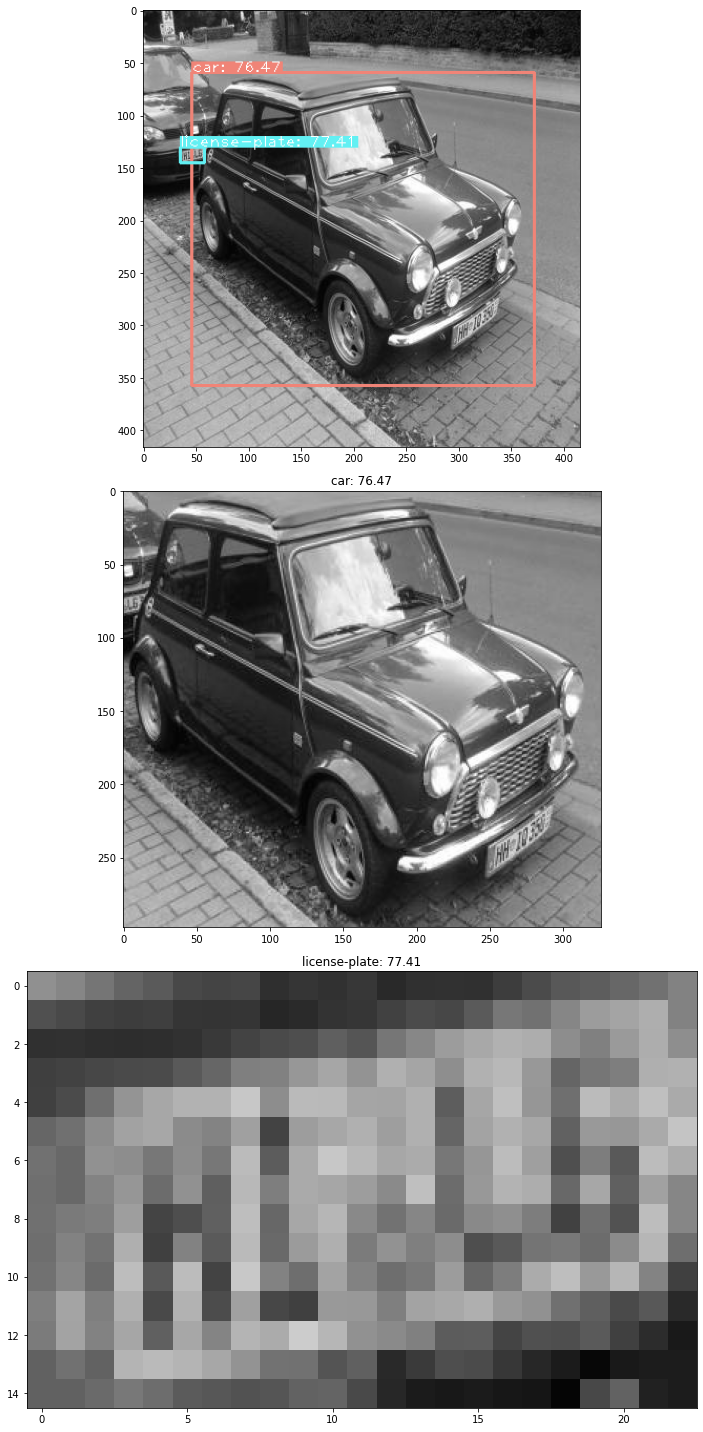

In [8]:
fig, axes = plt.subplots(nrows=(len(detections)+1), ncols=1, figsize=(20,20))

# original
axes[0].imshow(image)

# with detections
tmp = image.copy()
draw_bboxes(tmp, detections, image_resized)
axes[0].imshow(tmp)

for i, det in enumerate(detections):
    print(i,det)
    #tmp = image.copy()
    # crop
    _, __, bbox = det
    cropped = crop_to_bbox(bbox, image, image_resized)
    axes[i+1].imshow(cropped)
    axes[i+1].set_title(f'{det[0]}: {det[1]}')

# save cropped image
#cv2.imwrite('./crop.jpg', cropped)

plt.tight_layout()
plt.show()